In [2]:
import os
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn import metrics
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from collections import Counter
import itertools

[nltk_data] Downloading package stopwords to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Will
[nltk_data]     Boyd\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Load in the dictionary dataset into a pandas df
data_path = os.path.join(os.getcwd(), 'data', 'dictionary.txt')
dic = pd.read_csv(data_path, sep='|', header=None)

# ...and do the same with the sentiment_labels data
data_path = os.path.join(os.getcwd(), 'data', 'sentiment_labels.txt')
cents = pd.read_csv(data_path, sep='|')

dic = dic.rename(columns={0: "feature", 1: "ID"})# We rename the columns
# dic = dic.rename(index={range(239232)})
dic = dic.sort_values(by="ID") # We change the order of the rows to be sorted by ID number
movie_data = dic[["ID", "feature"]] # We change the order of the columns and change the name of the the df

# We make an array of the sentiments (already in the right order) and add it to our df
y = np.array(cents.iloc[:, -1])
movie_data.insert(2, "sentiment", y)

phrase_data = movie_data.sort_index()
phrase_data.drop("ID",axis=1,inplace=True)
phrase_data.insert(2,"label",0)

print(phrase_data.head())

       feature  sentiment  label
0            !    0.50000      0
1          ! '    0.52778      0
2         ! ''    0.50000      0
3       ! Alas    0.44444      0
4  ! Brilliant    0.86111      0


In [52]:
### We create a smaller subsample of the dataset - to speed up the computation when working on our code

# specify a smaller number of reviews
small_N = 23920

# choose small_N random and distinct integers between 0 and 239231
rand = random.sample(range(239231), small_N)

# find these indices in the original dictionary - and make a new array of them
rand_sample = phrase_data.iloc[rand]

rand_sample.head()

,feature,sentiment,label
120088,give him,0.50000,0
29254,Georgian-Israeli director Dover Kosashvili,0.50000,0
199826,that has all the elements necessary to be a fa...,0.37500,0
54969,There 's much tongue in cheek in the film and,0.47222,0
147381,kids-and-family-oriented,0.90278,0


In [4]:
### We can use the random sample or the full data set going forward

phrases = phrase_data
# phrases = rand_sample

In [5]:
### add correct labels based on sentiment column (uses qualities of numpy for efficiency)

np_phrase = np.array(phrases) # make it a numpy array

# create a series of boolean masks
vpos = (0.8 < np_phrase[:, 1]).astype(int)
pos =  (0.6 < np_phrase[:, 1]).astype(int)
ntrl = (0.4 < np_phrase[:, 1]).astype(int)
neg = (0.2 < np_phrase[:, 1]).astype(int)
vneg = (0 <= np_phrase[:, 1]).astype(int)

# add the masks together to get the correct label numbers for each review based on sentiment value
h = vneg + neg + ntrl + pos + vpos - 1

# update the array with our new values
np_phrase[:, 2] = h

# change back to a pandas
phrases = pd.DataFrame(np_phrase)

In [6]:
phrases.iloc[:, 0]

0                                                         !
1                                                       ! '
2                                                      ! ''
3                                                    ! Alas
4                                               ! Brilliant
                                ...                        
239227    zoning ordinances to protect your community fr...
239228                                            zzzzzzzzz
239229                                                 élan
239230                                                    É
239231                     É um passatempo descompromissado
Name: 0, Length: 239232, dtype: object

In [7]:
# Feature importance

filler_words = set(stopwords.words('english'))
lemmatize = WordNetLemmatizer()

#values =[[0, 0.2], [0.2, 0.4], [0.4, 0.6], [0.6, 0.8], [0.8, 1.0]]
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
to_drop = []

phrases_list = list(phrases.iloc[:, 0])

for i in range(len(phrases_list)):
    # 'clean' phrases: remove numbers, punctuation and filler words
    phrase = phrases_list[i]
    phrase = re.sub(r'[^\w]', " ", phrase) #remove all special characters 
    cleaned = re.sub(r'[\d]', " ", phrase)  #remove all numbers

    if (cleaned.replace(" ","")==""):
        to_drop.append(i)
        cleaned=""
    else:
        cleaned = word_tokenize(cleaned.lower()) #tokenise for bag of words
        cleaned = [w for w in cleaned if w not in filler_words] # #remove all filler words
        cleaned = [lemmatize.lemmatize(word) for word in cleaned]
    
    phrases_list[i] = cleaned
    
phrases.iloc[:, 0] = phrases_list

# remove unnecessary data
phrases.drop(1,axis=1,inplace=True) 
phrases.drop(to_drop,axis=0,inplace=True)
df = phrases[~phrases.astype(str).duplicated()]
df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)
print(df.head())
print(df.shape)

#save this as file
df.to_pickle("clean_doc.pkl", protocol=4)
# df.to_pickle("clean_phrase_data.pkl")

C:\Users\Will Boyd\AppData\Local\Temp\ipykernel_26088\3789690715.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop("index",axis=1,inplace=True)


                                           0  2
0                                      [ala]  2
1                                [brilliant]  4
2                                   [c, mon]  2
3          [gollum, performance, incredible]  3
4  [oh, look, clever, angle, wow, jump, cut]  1
(149902, 2)


In [9]:
# convert phrases to numerical representation: bag of words
phrases = pd.read_pickle("clean_rand_sample.pkl") 

#split phrase datasets to x and y
X = phrases.iloc[:, 0].copy()
# y = phrases.iloc[:, 2].copy()

# y = y.astype(int)
# np.save(y, "onehot_labels")

#create word vector 
vectorizer = CountVectorizer()
vectorizerfit = vectorizer.fit_transform(X.astype(str))
names = vectorizer.get_feature_names_out()
count_array = vectorizerfit.toarray()
vec = pd.DataFrame(data=count_array,columns=names)
vec.to_pickle("onehot_matrix", protocol=4)

In [23]:
#split test and train

x_train, x_test, y_train, y_test = train_test_split(vec, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(15451, 14219) (6622, 14219) (15451,)


In [24]:
#naive bayes
clf = MultinomialNB()
clf.fit(x_train,y_train)
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.753349297780079
0.49773482331621866


In [ ]:
#above not great, maybe add in a regulariser?

#confusion matrix
matrix = confusion_matrix(y_test,clf.predict(x_test), normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("NB_confused.png")
plt.show()

In [ ]:
# #random forest - grid search for optimal decision tree parameters -maybe try dif criterion
# rf_dic={
#     "n_estimators":[10,50,200,500],
#     "max_features": ["sqrt","log2"],
#     "criterion": ["gini"],
#     "max_depth": [4,8,30]
#     }

# rf = RandomForestClassifier(random_state=1)
# grid_search = GridSearchCV(estimator=rf,param_grid=rf_dic,cv=3)
# grid_search.fit(x_train,y_train)

# print("the best parameters are: " +str(grid_search.best_params_))

# print("accuracy: " + str(grid_search.best_estimator_.score(x_test, y_test)*100) + "%")

In [ ]:
# #confusion matrix
# matrix = confusion_matrix(y_test,grid_search.best_estimator_.predict(x_test), normalize='true')

# fig, ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(matrix, annot=True) 
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)
# ax.set_xlabel('predicted')
# ax.set_ylabel('true')
# # plt.savefig("RandForest_confused.png")
# plt.show()

In [25]:
#log reg

clf2 = LogisticRegression()
clf2.fit(x_train,y_train)
print(clf2.score(x_train,y_train))
print(clf2.score(x_test,y_test))

matrix2 = confusion_matrix(y_test,clf2.predict(x_test), normalize='true')

C:\Users\Will Boyd\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8106918646042327
0.540169133192389


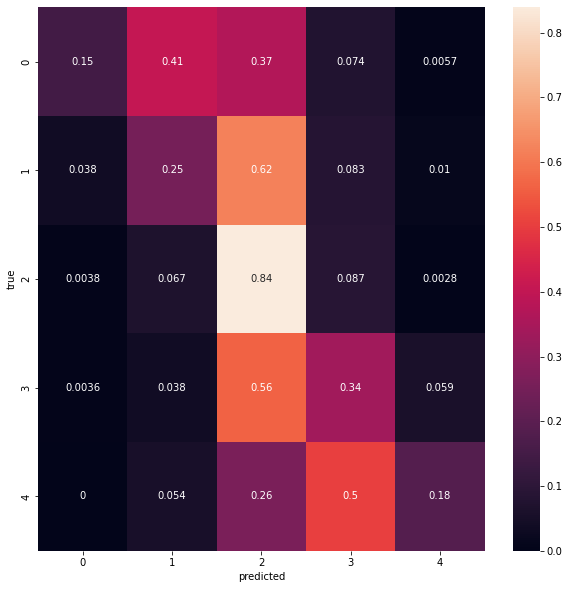

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix2, annot=True) 
ax.set_xticklabels([0, 1, 2, 3, 4])
ax.set_yticklabels([0, 1, 2, 3, 4])
ax.set_xlabel('predicted')
ax.set_ylabel('true')
# plt.savefig("logreg_confused.png")
plt.show()